# Forecasting a timeseries

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")  # ignore convergence warnings

In [2]:
path = Path('CTA_-_Ridership_-_Daily_Boarding_Totals_20250901.csv')
df = pd.read_csv(path, parse_dates=['service_date'])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months 

df.dtypes

day_type    object
bus         object
rail        object
dtype: object

## Convert Bus and Rail into numeric data

In [3]:
df["bus"] = df["bus"].astype(str).str.replace(",", "").astype(int)
df["rail"] = df["rail"].astype(str).str.replace(",", "").astype(int)

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


## W - means weekdays , A - Saturday, U - Sunday

In [5]:
df.tail()

,day_type,bus,rail
date,,,
2025-06-26,W,561301,471300
2025-06-27,W,543140,416639
2025-06-28,A,427366,337560
2025-06-29,U,316118,323242
2025-06-30,W,534839,376363


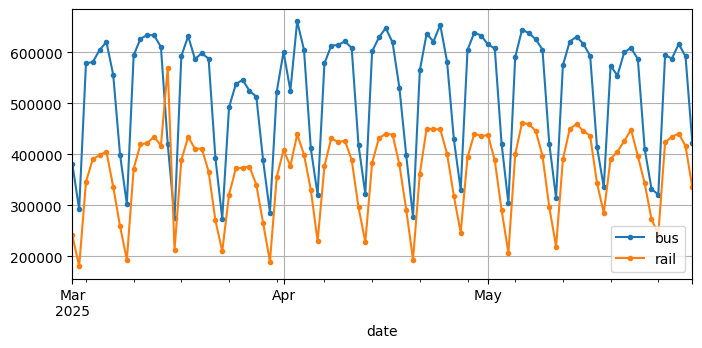

In [6]:
df.loc["2025-03":"2025-05"].plot(grid=True, marker='.', figsize=(8,3.5))
plt.show()

# Naive Forecasting

---
The naive forecasting is adopting the current/previous day, week, month data to forecast the next day, week, or month. This can serve as a baseline forecast.

From the graph below, we use the previous 7 days to forecast the next 7 days for the period of March to May 2021 and it was very close in its predictions.

---

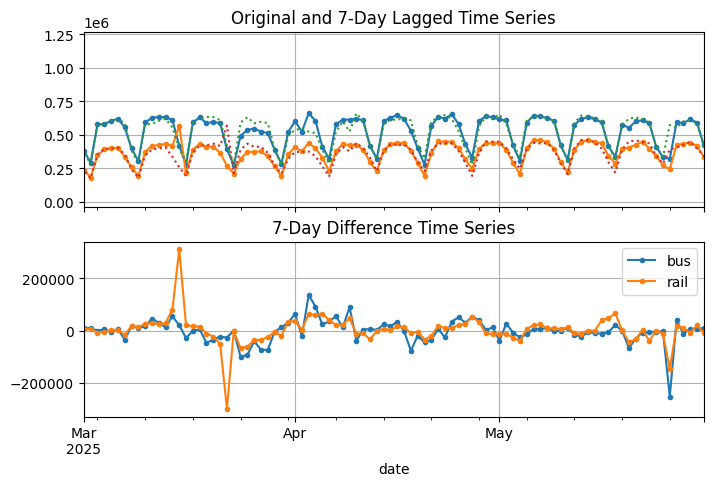

In [7]:
diff_7 = df[['bus', 'rail']].diff(7)["2025-03":"2025-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
axs[0].set_title("Original and 7-Day Lagged Time Series")


df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[1].set_title("7-Day Difference Time Series")

plt.show()

### Lets get the Mean Absolute Error for the period

In [8]:
diff_7.abs().mean()

bus     28896.891304
rail    29453.489130
dtype: float64

### Get the Mean Abssolute Percentage Error (MAPE) 

In [9]:
targets = df[['bus', 'rail']]["2025-03":"2025-05"]
(diff_7/targets).abs().mean()

bus     0.059459
rail    0.086405
dtype: float64

---
We can notice that the bus has a better MAE but worse MAPE than that of rail, however, the MAPE is very close for both bus and rail compared to the MAE.

This is because bus ridership are larger hence their forecast error will also be larger. But the percentage error will put things in the proper perspective.

MAPE : 
bus - 5.9% ; 
rail - 8.6%

---

In [10]:
def naive_next(df_slice, df_full, cols, seasonal=False, season=7):
    """
    Naive or seasonal naive forecast for the next day,
    using a pre-sliced DataFrame for the forecast, 
    and the full DataFrame for the observed value.

    Parameters
    ----------
    df_slice : pd.DataFrame
        Pre-sliced DataFrame (e.g., df.loc["2025-03":"2025-05"])
    df_full : pd.DataFrame
        The original full DataFrame containing all dates
    cols : list
        List of numeric columns to forecast (e.g., ["bus", "rail"])
    seasonal : bool, default False
        If True, use seasonal naive (t = t-season)
    season : int, default 7
        Seasonal lag (e.g., 7 for weekly)

    Returns
    -------
    dict with:
        - forecast : pd.DataFrame
        - observed : pd.Series (true next-day values from df_full)
    """
    df_slice = df_slice.sort_index()
    
    # last day in the slice and next day
    last_day = df_slice.index[-1]
    next_day = last_day + pd.Timedelta(days=1)

    # forecast
    if seasonal:
        vals = df_slice.loc[last_day - pd.Timedelta(days=season-1), cols]
    else:
        vals = df_slice.loc[last_day, cols]
    forecast = pd.DataFrame([vals.values], index=[next_day], columns=cols)

    # true observed value from full df
    observed = df_full.loc[next_day, cols] if next_day in df_full.index else None

    return {"forecast": forecast, "observed": observed}


In [11]:
# Slice your data
df_slice = df.loc["2025-03":"2025-05"]

# Call the function with the slice and the full DataFrame
result_naive = naive_next(df_slice, df, ["bus", "rail"])
result_seasonal = naive_next(df_slice, df, ["bus", "rail"], seasonal=True)

# Print results
print("Naive forecast:\n", result_naive["forecast"], "\n")
print("Observed:\n", result_naive["observed"], "\n")

print("Seasonal naive forecast:\n", result_seasonal["forecast"], "\n")
print("Observed:\n", result_seasonal["observed"])


Naive forecast:
                bus    rail
2025-06-01  421327  334489 

Observed:
 bus     322578
rail    268696
Name: 2025-06-01 00:00:00, dtype: object 

Seasonal naive forecast:
                bus    rail
2025-06-01  331906  272960 

Observed:
 bus     322578
rail    268696
Name: 2025-06-01 00:00:00, dtype: object


---
The Naive forecast using day for bus is 468550 while rail is 326376, however using the 7 days period - for bus is 461780 for rail 319883 

---

### Yearly Seasonality - 2001 to 2023

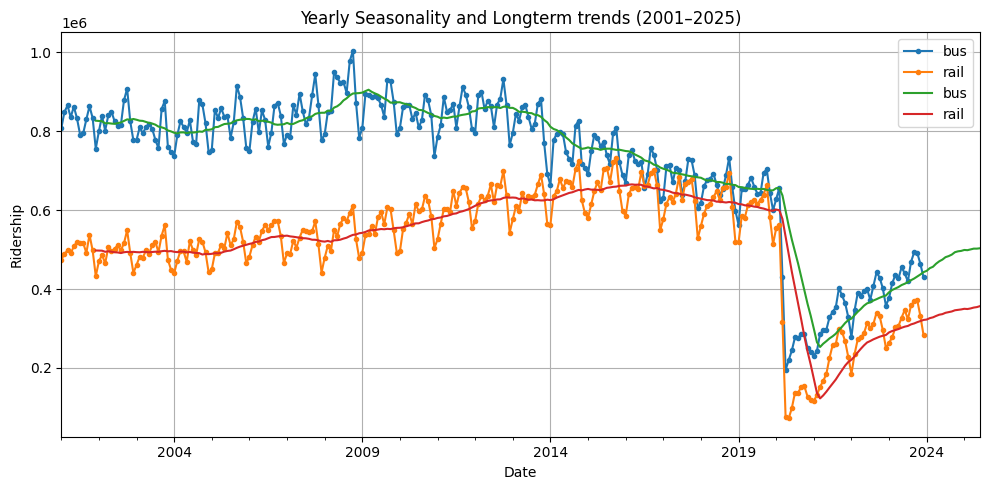

In [12]:
period = slice("2001", "2025") 

# Select only numeric columns
df_numeric = df[["bus", "rail"]]

# Resample monthly and compute mean
df_monthly = df_numeric.resample('M').mean()

# 12-month rolling average
rolling_average_12_months = df_monthly["2001":"2025"].rolling(window=12).mean()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
df_monthly["2001":"2023"].plot(ax=ax, marker=".", label="Monthly Mean")
rolling_average_12_months.plot(ax=ax, grid=True, label="12-Month Rolling Avg")
ax.set_title("Yearly Seasonality and Longterm trends (2001–2025)")
ax.set_xlabel("Date")
ax.set_ylabel("Ridership")
ax.legend()
plt.tight_layout()
plt.show()


### The 12-Months difference

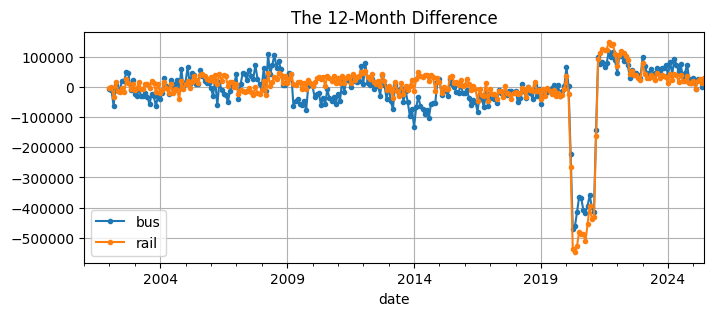

In [13]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.gca().set_title("The 12-Month Difference")
plt.show()

---
The difference removed the yearly seasonality forecast except for the year 2020 which is the period of COVID/Lock Down

---

# ARMA MODELS - autoregressive moving average model

---
## What ARMA stands for

ARMA = AutoRegressive Moving Average.
It’s a statistical model used to predict future values of a time series (like stock prices, temperature, or ridership) based on its past behavior.

It has two parts:

- AR (AutoRegressive) – uses past values of the series itself.

- MA (Moving Average) – uses past “errors” or shocks (differences between actual and predicted values).

## AutoRegressive (AR) part

- Think of it like this: the future value depends on some number of past values.

- Example: today’s temperature might depend on yesterday’s temperature and the day before.

- We call the number of past values we use p, the “order” of the AR part.

$$
X_t = c + \phi_1 X_{t-1} + \cdots + \phi_p X_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q} + error
$$

$$
\begin{aligned}
\text{Where:} \\
X_t &= \text{value at time } t \\
c &= \text{constant term} \\
\phi_1, \phi_2, \dots, \phi_p &= \text{coefficients (how much past values influence the current value)} \\
\text{error} &= \text{random noise}
\end{aligned}
$$

## Moving Average (MA) part

This part looks at past errors instead of past values.

Why? Sometimes patterns are not obvious from past values alone, but the mistakes we made in predicting before can help forecast future values.

We call the number of past errors we include q, the “order” of the MA part.

$$
\begin{aligned}
X_t &= c + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} \\[1mm]
\text{Where:} \\
\theta_1, \theta_2, \dots, \theta_q &= \text{coefficients for past errors} \\
\epsilon_t &= \text{random noise at time } t
\end{aligned}
$$

## ARMA combines both

An ARMA(p, q) model uses both: p past values (AR) q past errors (MA)

$$
\begin{aligned}
X_t &= c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_p X_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} \\[1mm]
\text{Where:} \\
X_t &= \text{value at time } t \\
c &= \text{constant term} \\
\phi_1, \phi_2, \dots, \phi_p &= \text{coefficients for past values (AR part)} \\
\theta_1, \theta_2, \dots, \theta_q &= \text{coefficients for past errors (MA part)} \\
\epsilon_t &= \text{random noise at time } t
\end{aligned}
$$

## Key points to remember

Stationarity: ARMA works best when the data fluctuates around a constant mean and variance over time. If the series trends upwards or grows, we usually difference it first (leading to ARIMA).

p and q: These are the “orders” you choose based on patterns in the data (autocorrelation and partial autocorrelation plots help).

Error term: Random noise in your data that you can’t predict.

## Intuition / Example

Imagine you’re forecasting daily bus ridership:

AR part: “Ridership today is probably similar to yesterday and the day before.”

MA part: “Yesterday we overpredicted by 500 passengers, so maybe today will be slightly lower to compensate.”

Combine both, and ARMA gives a formula that weighs past ridership and past mistakes to make the best estimate for today.

## This model assumes stationarity  of the series

---

In [14]:
from statsmodels.tsa.arima.model import ARIMA

## ARIMA
---
1. AR (Autoregressive) – “I look at the past”

Idea: Today’s value depends on previous days.

Example: If yesterday 100 people rode the train, today might be similar, maybe a bit more or less.

Parameter p = how many previous days you consider.

2. MA (Moving Average) – “I fix past mistakes”

Idea: If my past predictions were off, I adjust today’s forecast to compensate.

Example: Yesterday I predicted 110 riders but only 100 came. Today I’ll adjust down a bit.

Parameter q = how many past prediction mistakes I consider.

3. I (Integrated / Differencing) – “I remove trends”

Idea: If the series is trending up or down, we first look at changes rather than raw numbers.

Example: Instead of looking at 100 → 110 → 120, look at the differences: +10, +10.

Parameter d = how many times we calculate these changes to make the series stable.

4. Seasonal part – “I look at repeating patterns”

Idea: Some patterns repeat after a fixed time (like weekly or monthly).

Example: Train rides go up on Mondays and down on Sundays. That’s weekly seasonality.

Seasonal parameters (P, D, Q, s):

P = AR for seasonal pattern (depends on same day last week)

D = differencing to remove seasonal trend

Q = MA for seasonal errors

s = length of the season (7 for a week, 12 for months)

5. Your model in layman terms
order=(1,0,0)
seasonal_order=(0,1,1,7)


Look at yesterday’s rides to predict today (AR(1))

Ignore overall trend (d=0)

Weekly pattern: subtract last week’s value to remove seasonality (D=1, s=7)

Adjust for last week’s prediction error (Q=1)

✅ In short: “Today’s train rides = yesterday’s rides + weekly pattern + small adjustment for last week’s mistake.”

---

In [15]:
origin, today = "2025-01-01", "2025-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series, order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()

In [16]:
print(y_pred)

2025-06-01    260176.111208
Freq: D, dtype: float64


---
from the forecast with the ARIMA model(317978), we can see that it is worse than the Naive Forecasting(319883). The observed is 346924

---

# Lets check the MAE for the ARIMA model to see its performance on more days.

In [17]:
origin, start_date, end_date = "2025-01-01", "2025-03-01", "2025-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)
y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  
print(mae)

25162.19345016908


In [18]:
print(mae)

25162.19345016908


---
The MAE for the ARIMA model is 20,600.8 compared to the Naive Forecasting 21245.152174. Therefore the ARIMA model is better but just slightly off for the prediction on 1st June 2025.

---

# GRIDSEARCH

---
At this point, the Naive forecast got a better forecast for the 1st of June 2025, however the MAE is higher than that of the ARIMA model which means in the long run the model would get alot wrong that the ARIMA model.

|                          | Seasonal Naive Forecast |   ARIMA   |
|--------------------------|--------------------------|-----------|
| **MAE**                  | 29,453.49                | 25,162.19 |
| **Forecast (1st June 2025)** | 268,696                  | 260,176.11 |
| **Observed**             | 272,960                  | 272,960   |
| **Error %**              | 1.56%                    | 4.68%     |


---


# Preparing Data For Deep Learning

In [19]:
rail_train = df["rail"]["2022-01":"2024-12"] / 1e6
rail_valid = df["rail"]["2025-01":"2025-05"] / 1e6
rail_test = df["rail"]["2025-06":] / 1e6

In [20]:
seq_length = 56

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)


## Forecasting Using a Linear Model

In [21]:
tf.random.set_seed(42)

model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[seq_length])])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 7s 39ms/step - loss: 0.0086 - mae: 0.1032 - val_loss: 0.0087 - val_mae: 0.1060
Epoch 2/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0051 - mae: 0.0776 - val_loss: 0.0049 - val_mae: 0.0780
Epoch 3/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0039 - mae: 0.0690 - val_loss: 0.0041 - val_mae: 0.0701
Epoch 4/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0035 - mae: 0.0640 - val_loss: 0.0047 - val_mae: 0.0771
Epoch 5/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0032 - mae: 0.0615 - val_loss: 0.0042 - val_mae: 0.0730
Epoch 6/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0030 - mae: 0.0596 - val_loss: 0.0032 - val_mae: 0.0613
Epoch 7/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0027 - mae: 0.0564 - val_loss: 0.0029 - val_mae: 0.0578
Epoch 8/500
33/33 [==============================] - 1s 22ms/step - loss: 0.

In [32]:
def get_val_mae(history=history):
    # Extract validation MAE history
    val_mae = history.history["val_mae"]
    
    # Find the index of the minimum val_mae
    best_epoch = np.argmin(val_mae) + 1  # +1 because epochs are 1-based
    best_val_mae = val_mae[best_epoch - 1]
    
    print(f"Best epoch: {best_epoch}, Best val_mae: {best_val_mae:.4f}")


In [23]:
# Extract validation MAE history
val_mae = history.history["val_mae"]

# Find the index of the minimum val_mae
best_epoch = np.argmin(val_mae) + 1  # +1 because epochs are 1-based
best_val_mae = val_mae[best_epoch - 1]

print(f"Best epoch: {best_epoch}, Best val_mae: {best_val_mae:.4f}")


get_val_mae(history=history)

Best epoch: 488, Best val_mae: 0.0238


In [24]:

# Last 56 values from your series
last_window = rail_series[-seq_length:].values  

# Reshape into (1, 56) because the model expects batch input
X_input = last_window.reshape(1, -1)

# Predict next day
next_day_pred = model.predict(X_input)[0][0]
print(f"Next day forecast: {next_day_pred:.2f}")


1/1 [==============================] - 0s 283ms/step
Next day forecast: 218240.92


In [29]:
def plot_history(history = history):
    # Extract history
    history_dict = history.history
    
    # Plot Loss
    plt.figure(figsize=(10,5))
    plt.plot(history_dict["loss"], label="Training Loss")
    plt.plot(history_dict["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Huber)")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()
    
    # Plot MAE
    plt.figure(figsize=(10,5))
    plt.plot(history_dict["mae"], label="Training MAE")
    plt.plot(history_dict["val_mae"], label="Validation MAE")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.title("Training vs Validation MAE")
    plt.legend()
    plt.show()

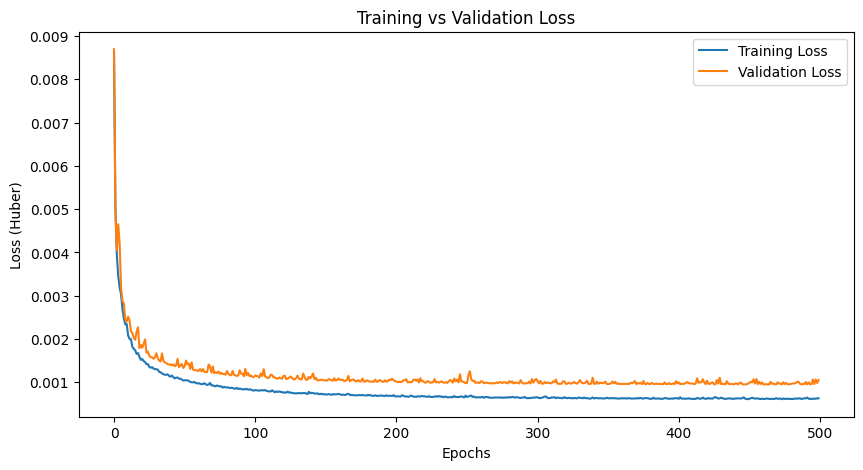

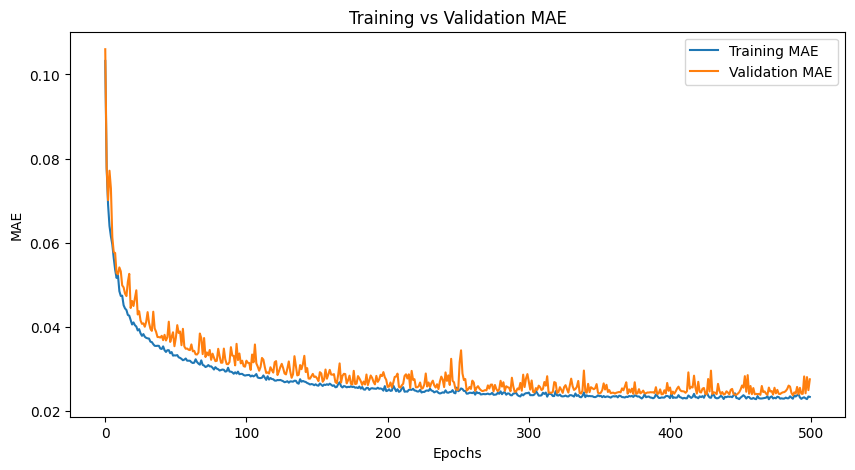

In [22]:
plot_history(history = history)

---
# Forecast Comparison

|                          | Seasonal Naive Forecast | ARIMA        | Linear Model  |
|--------------------------|------------------------|-------------|---------------|
| **MAE**                  | 29,453.49             | 25,162.19   | 23,800        |
| **Forecast (1st June 2025)** | 268,696           | 260,176.11  | 218,240.92    |
| **Observed**             | 272,960               | 272,960     | 272,960       |
| **Error %**              | 1.56%                 | 4.68%       | 20.05%        |

- Looking at the **overall MAE**, the **Linear Model** performs best with the lowest MAE (23,800).  
- However, for the specific forecast of **June 1st, 2025**, the **Seasonal Naive Forecast** was closest to the observed value.  

---


# Forecasting Using a Simple RNN

In [26]:
univar_model = tf.keras.Sequential([
 tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
 tf.keras.layers.Dense(1)  # no activation function by default
 ])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

univar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = univar_model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])


Epoch 1/500
33/33 [==============================] - 9s 186ms/step - loss: 0.0252 - mae: 0.1588 - val_loss: 0.0098 - val_mae: 0.1229
Epoch 2/500
33/33 [==============================] - 6s 172ms/step - loss: 0.0056 - mae: 0.0869 - val_loss: 0.0043 - val_mae: 0.0772
Epoch 3/500
33/33 [==============================] - 6s 177ms/step - loss: 0.0049 - mae: 0.0812 - val_loss: 0.0061 - val_mae: 0.0971
Epoch 4/500
33/33 [==============================] - 5s 161ms/step - loss: 0.0044 - mae: 0.0765 - val_loss: 0.0062 - val_mae: 0.0986
Epoch 5/500
33/33 [==============================] - 6s 164ms/step - loss: 0.0042 - mae: 0.0749 - val_loss: 0.0037 - val_mae: 0.0689
Epoch 6/500
33/33 [==============================] - 5s 160ms/step - loss: 0.0042 - mae: 0.0741 - val_loss: 0.0075 - val_mae: 0.1095
Epoch 7/500
33/33 [==============================] - 5s 160ms/step - loss: 0.0038 - mae: 0.0712 - val_loss: 0.0045 - val_mae: 0.0843
Epoch 8/500
33/33 [==============================] - 5s 161ms/step - 

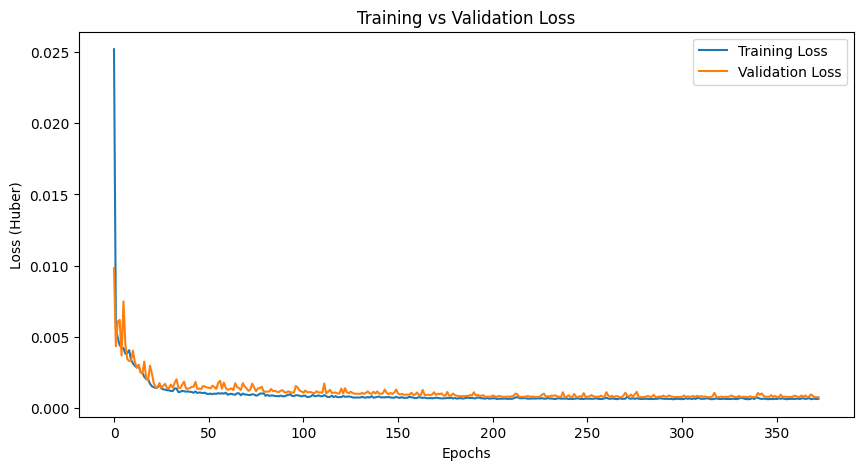

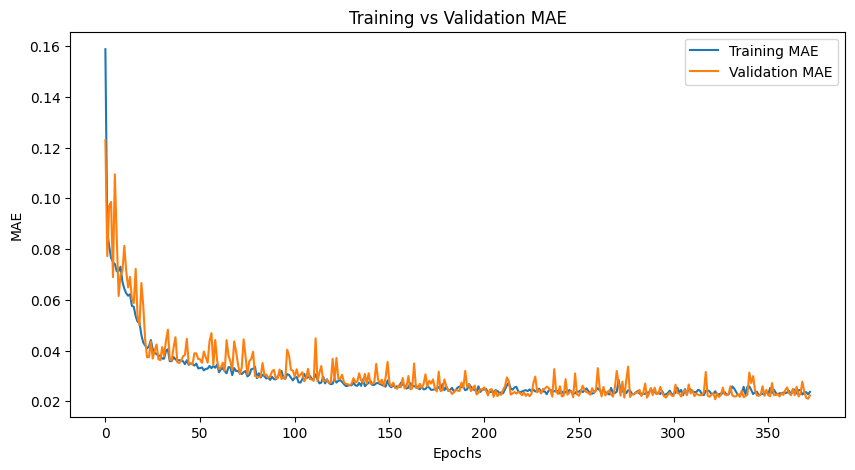

In [30]:
plot_history(history = history)

## Get the Validation MAE for Simple RNN

In [33]:
get_val_mae(history=history)

Best epoch: 323, Best val_mae: 0.0208


## Function to forecast N number of days

In [36]:
def forecast_next_n_days(model, series, seq_length, n_steps=1):
    """
    Forecast the next n_steps using a trained RNN model.
    
    Parameters:
    - model: trained Keras RNN model
    - series: 1D numpy array or pandas series of time series data
    - seq_length: number of timesteps used as input for the model
    - n_steps: number of steps ahead to forecast (default 1)
    
    Returns:
    - preds: list of forecasted values
    """
    
    # Get the last seq_length values
    window = series[-seq_length:].reshape(1, seq_length, 1)
    preds = []
    
    for _ in range(n_steps):
        y_pred = model.predict(window, verbose=0)[0][0]
        preds.append(y_pred)
        
        # Slide the window for the next step
        window = np.concatenate([window[:, 1:, :], y_pred.reshape(1, 1, 1)], axis=1)
    
    return preds


In [41]:
next_day = forecast_next_n_days(univar_model, rail_valid.to_numpy(), seq_length=56, n_steps=1) 
print("Next day forecast:", next_day[0] * 1e6)
original = df["rail"]["2025-06-01"]
print("Next day original:", original)

Next day forecast: 260839.67089653015
Next day original: 268696


In [126]:
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    print(y_pred_one)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 60ms/step
[[0.39945248]]
1/1 [==============================] - 0s 96ms/step
[[0.39485353]]
1/1 [==============================] - 0s 91ms/step
[[0.32860473]]
1/1 [==============================] - 0s 100ms/step
[[0.23291793]]
1/1 [==============================] - 0s 98ms/step
[[0.18401295]]
1/1 [==============================] - 0s 103ms/step
[[0.32326669]]
1/1 [==============================] - 0s 85ms/step
[[0.39352763]]
1/1 [==============================] - 0s 87ms/step
[[0.3973089]]
1/1 [==============================] - 0s 104ms/step
[[0.3918035]]
1/1 [==============================] - 0s 101ms/step
[[0.333158]]
1/1 [==============================] - 0s 86ms/step
[[0.23394674]]
1/1 [==============================] - 0s 107ms/step
[[0.18095183]]
1/1 [==============================] - 0s 96ms/step
[[0.32027805]]
1/1 [==============================] - 0s 102ms/step
[[0.39501488]]


In [125]:
print(y_pred_one)

[[0.39501488]]


# Forecast Comparison


|                          | Seasonal Naive Forecast | ARIMA        | Linear Model  | Simple RNN  |
|--------------------------|------------------------|-------------|---------------|-------------|
| **MAE**                  | 29,453.49             | 25,162.19   | 23,800        | 20,800      |
| **Forecast (1st June 2025)** | 272,960           | 260,176.11  | 218,240.92    | 260,839.67  |
| **Observed**             | 268,696               | 268,696     | 268,696       | 268,696     |
| **Error %**              | 1.58%                 | 3.15%       | 18.73%       | 2.92%       |
 
- For the **specific forecast of June 1st, 2025**, the **Seasonal Naive Forecast** is closest to the observed value.  
- For **overall long-term performance**, the **Simple RNN** achieves the lowest MAE, making it the best choice for general forecasting.  
- **Recommendation:** Use **Simple RNN** for long-term predictions and **Naive Forecast** if a single-day accuracy is the main priority.


# FORECASTING USING A DEEP RNN

---
- tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
- tf.keras.layers.SimpleRNN(32, return_sequences=True),

the above is a sequence to sequence layer while the below is a sequence to vector layer

- tf.keras.layers.SimpleRNN(32, return_sequences=True),
- tf.keras.layers.SimpleRNN(32),

---


In [43]:
deep_model = tf.keras.Sequential([
 tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
 tf.keras.layers.SimpleRNN(32, return_sequences=True),
 tf.keras.layers.SimpleRNN(32),
 tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

deep_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = deep_model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 30s 716ms/step - loss: 0.0249 - mae: 0.1697 - val_loss: 0.0030 - val_mae: 0.0564
Epoch 2/500
33/33 [==============================] - 21s 641ms/step - loss: 0.0027 - mae: 0.0578 - val_loss: 0.0022 - val_mae: 0.0541
Epoch 3/500
33/33 [==============================] - 21s 633ms/step - loss: 0.0020 - mae: 0.0501 - val_loss: 0.0015 - val_mae: 0.0400
Epoch 4/500
33/33 [==============================] - 22s 659ms/step - loss: 0.0015 - mae: 0.0408 - val_loss: 0.0030 - val_mae: 0.0652
Epoch 5/500
33/33 [==============================] - 22s 659ms/step - loss: 0.0014 - mae: 0.0395 - val_loss: 0.0015 - val_mae: 0.0390
Epoch 6/500
33/33 [==============================] - 22s 661ms/step - loss: 0.0012 - mae: 0.0346 - val_loss: 0.0025 - val_mae: 0.0573
Epoch 7/500
33/33 [==============================] - 21s 645ms/step - loss: 0.0012 - mae: 0.0364 - val_loss: 0.0017 - val_mae: 0.0437
Epoch 8/500
33/33 [==============================] - 22s 664ms

In [44]:
get_val_mae(history=history)

Best epoch: 82, Best val_mae: 0.0221


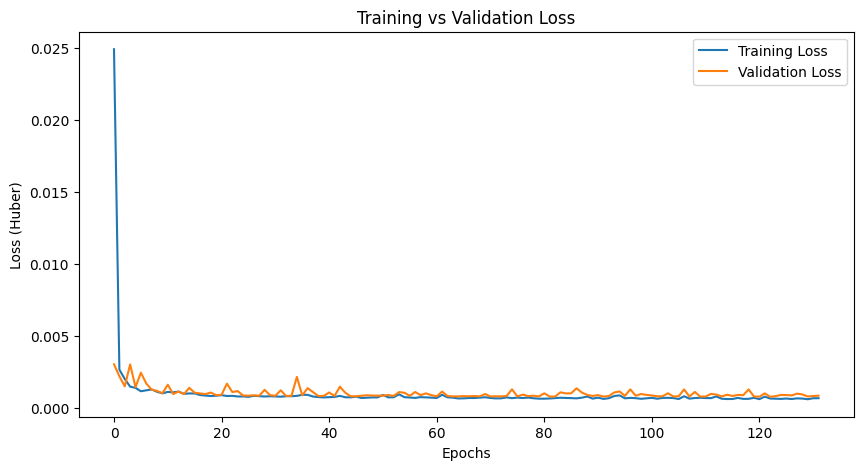

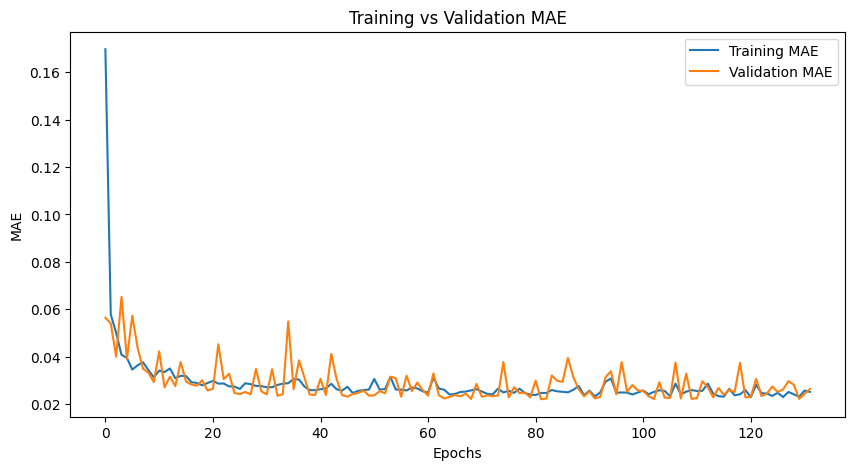

In [45]:
plot_history(history = history)

In [46]:
next_day = forecast_next_n_days(deep_model, rail_valid.to_numpy(), seq_length=56, n_steps=1) 
print("Next day forecast:", next_day[0] * 1e6)
original = df["rail"]["2025-06-01"]
print("Next day original:", original)

Next day forecast: 254230.5588722229
Next day original: 268696


In [ ]:
 X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
 for step_ahead in range(14):
 y_pred_one = univar_model.predict(X)
 X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

# Forecast Comparison

|                          | Seasonal Naive Forecast | ARIMA        | Linear Model  | Simple RNN  | Deep RNN   |
|--------------------------|------------------------|-------------|---------------|-------------|------------|
| **MAE**                  | 29,453.49             | 25,162.19   | 23,800        | 20,800      | 22,100     |
| **Forecast (1st June 2025)** | 272,960           | 260,176.11  | 218,240.92    | 260,839.67  | 254,230.56 |
| **Observed**             | 268,696               | 268,696     | 268,696       | 268,696     | 268,696    |
| **Error %**              | 1.58%                 | 3.15%       | 18.73%        | 2.92%       | 5.40%      |


- The **Seasonal Naive Forecast** remains the most accurate for June 1st, 2025, with the lowest single-day error (1.58%).  
- **Simple RNN** continues to be the best performer in terms of overall MAE (20,800).  
- The **Deep RNN** performs slightly worse than ARIMA and Simple RNN for this specific day (5.40% error), though its MAE is competitive at 22,100.  
- **Linear Model** significantly underestimates this day’s value despite a relatively low MAE overall.  


# USING MULTIVARIATE RNN TIME SERIES TO FORECAST FOR RAIL

In [48]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


In [66]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

# Drop the last row since shift(-1) creates a NaN
df_mulvar = df_mulvar.dropna()

# Convert everything to float32
df_mulvar = df_mulvar.astype("float32")

In [67]:
mulvar_train = df_mulvar["2022-01":"2024-12"] 
mulvar_valid = df_mulvar["2025-01":"2025-05"]
mulvar_test = df_mulvar["2025-06":]

In [68]:
mulvar_train.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2022-01-01,0.115581,0.116473,0.0,1.0,0.0
2022-01-02,0.141100,0.114070,0.0,0.0,1.0
2022-01-03,0.308893,0.184727,0.0,0.0,1.0
2022-01-04,0.343163,0.202963,0.0,0.0,1.0
2022-01-05,0.261752,0.177105,0.0,0.0,1.0


## Get the column length 

In [69]:
len_col = mulvar_train.shape[1]

In [72]:
## Create the dataset and we forecast only for rail data
seq_length = 56

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train['rail'][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid['rail'][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)


# Create the RNN Model

In [75]:
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, len_col]), # len_col is 5 due to the one-hot encoding
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

mulvar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = mulvar_model.fit(train_mulvar_ds, validation_data=valid_mulvar_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 9s 208ms/step - loss: 0.0066 - mae: 0.0855 - val_loss: 0.0030 - val_mae: 0.0581
Epoch 2/500
33/33 [==============================] - 6s 164ms/step - loss: 0.0023 - mae: 0.0511 - val_loss: 0.0015 - val_mae: 0.0398
Epoch 3/500
33/33 [==============================] - 5s 163ms/step - loss: 0.0015 - mae: 0.0411 - val_loss: 0.0014 - val_mae: 0.0392
Epoch 4/500
33/33 [==============================] - 5s 161ms/step - loss: 0.0012 - mae: 0.0373 - val_loss: 0.0012 - val_mae: 0.0372
Epoch 5/500
33/33 [==============================] - 6s 167ms/step - loss: 0.0012 - mae: 0.0367 - val_loss: 0.0010 - val_mae: 0.0329
Epoch 6/500
33/33 [==============================] - 6s 168ms/step - loss: 0.0011 - mae: 0.0344 - val_loss: 9.7442e-04 - val_mae: 0.0323
Epoch 7/500
33/33 [==============================] - 6s 161ms/step - loss: 9.9085e-04 - mae: 0.0329 - val_loss: 8.9884e-04 - val_mae: 0.0305
Epoch 8/500
33/33 [==============================] - 5s 1

In [76]:
get_val_mae(history=history)

Best epoch: 88, Best val_mae: 0.0201


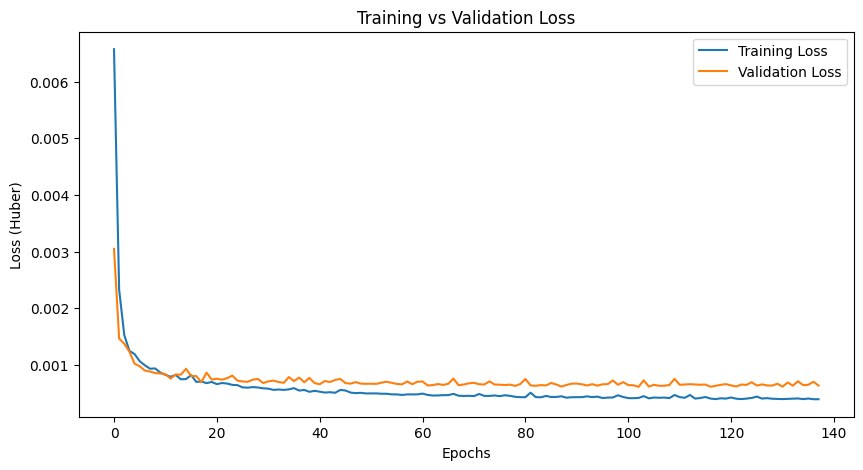

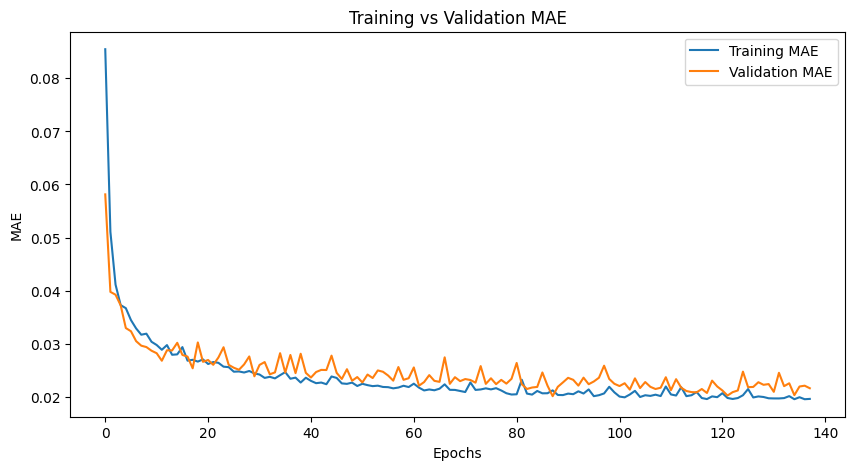

In [77]:
plot_history(history=history)

In [83]:
def forecast_next_n_days(model, series, seq_length, n_steps=1, target_col=None):
    """
    Forecast the next n_steps using a trained RNN model (uni- or multivariate).
    
    Parameters:
    - model: trained Keras RNN model
    - series: 2D numpy array (time x features) or 1D array (time,)
    - seq_length: number of timesteps for input window
    - n_steps: number of steps ahead to forecast
    - target_col: index of the target feature to forecast (e.g. 1 for 'rail').
                  If None, forecasts the full feature vector.
    
    Returns:
    - preds: list of forecasted values (target only if target_col given, else full vectors)
    """
    # Ensure 2D (time, features)
    if series.ndim == 1:
        series = series.reshape(-1, 1)
    
    n_features = series.shape[1]
    window = series[-seq_length:].reshape(1, seq_length, n_features)
    preds = []
    
    for _ in range(n_steps):
        y_pred = model.predict(window, verbose=0)
        
        if target_col is not None:  
            # Single target forecast
            y_val = y_pred[0][0] if y_pred.shape[-1] == 1 else y_pred[0][target_col]
            preds.append(y_val)
            
            # Extend window: copy last row, replace target_col with prediction
            next_step = window[:, -1:, :].copy()
            next_step[0, 0, target_col] = y_val
        else:
            # Forecast all features
            y_val = y_pred[0]
            preds.append(y_val)
            
            # Extend window: replace entire last row with prediction
            next_step = y_val.reshape(1, 1, -1)
        
        # Slide window forward
        window = np.concatenate([window[:, 1:, :], next_step], axis=1)
    
    return preds


In [84]:
next_day = forecast_next_n_days(mulvar_model, mulvar_valid.to_numpy(), seq_length=56, n_steps=1, target_col=1)
print("Next day rail forecast:", next_day[0] * 1e6)

original = df["rail"]["2025-06-01"]
print("Next day original:", original)

Next day rail forecast: 261113.34562301636
Next day original: 268696


# Forecast Comparison

|                          | Seasonal Naive Forecast | ARIMA        | Linear Model  | Simple RNN  | Deep RNN   | Multivar_model |
|--------------------------|------------------------|-------------|---------------|-------------|------------|----------------|
| **MAE**                  | 29,453.49             | 25,162.19   | 23,800        | 20,800      | 22,100     | 20,100         |
| **Forecast (1st June 2025)** | 272,960           | 260,176.11  | 218,240.92    | 260,839.67  | 254,230.56 | 261,113.35     |
| **Observed**             | 268,696               | 268,696     | 268,696       | 268,696     | 268,696    | 268,696        |
| **Error %**              | 1.58%                 | 3.15%       | 18.73%        | 2.92%       | 5.40%      | 2.90%          |

- The **Seasonal Naive Forecast** remains the most accurate for June 1st, 2025, with the lowest single-day error (1.58%).  
- **Multivar_model** slightly outperforms Simple RNN in overall MAE (20,100 vs 20,800) and has a very small single-day error (2.90%), making it the best model overall.  
- **Simple RNN** continues to be highly competitive, with a low MAE (20,800) and small single-day error (2.92%).  
- **Deep RNN** performs slightly worse than ARIMA and Simple RNN for this specific day (5.40% error), though its MAE is still competitive (22,100).  
- **Linear Model** significantly underestimates this day’s value despite a relatively low MAE overall.  
- **ARIMA** performs reasonably well with an MAE of 25,162 and a single-day error of 3.15%.  


# FORECAST SEVERAL TIME STEPS AHEAD

In [86]:
ahead = 14 # forcast the next 14 days

def split_inputs_and_targets(mulvar_series, ahead=ahead, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]
    
ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + ahead,
    batch_size=32,
    shuffle=True,
    seed=42).map(split_inputs_and_targets)


ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + ahead,
    batch_size=32).map(split_inputs_and_targets)

# 14 days ahead Model

In [87]:
ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

ahead_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = ahead_model.fit(ahead_train_ds, validation_data=ahead_valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 9s 185ms/step - loss: 0.0367 - mae: 0.2004 - val_loss: 0.0099 - val_mae: 0.1128
Epoch 2/500
33/33 [==============================] - 6s 164ms/step - loss: 0.0074 - mae: 0.0963 - val_loss: 0.0057 - val_mae: 0.0856
Epoch 3/500
33/33 [==============================] - 6s 169ms/step - loss: 0.0051 - mae: 0.0805 - val_loss: 0.0048 - val_mae: 0.0806
Epoch 4/500
33/33 [==============================] - 5s 159ms/step - loss: 0.0043 - mae: 0.0743 - val_loss: 0.0044 - val_mae: 0.0773
Epoch 5/500
33/33 [==============================] - 6s 164ms/step - loss: 0.0038 - mae: 0.0704 - val_loss: 0.0040 - val_mae: 0.0740
Epoch 6/500
33/33 [==============================] - 6s 167ms/step - loss: 0.0035 - mae: 0.0675 - val_loss: 0.0038 - val_mae: 0.0716
Epoch 7/500
33/33 [==============================] - 6s 165ms/step - loss: 0.0033 - mae: 0.0654 - val_loss: 0.0036 - val_mae: 0.0697
Epoch 8/500
33/33 [==============================] - 5s 160ms/step - 

In [88]:
get_val_mae(history=history)

Best epoch: 483, Best val_mae: 0.0303


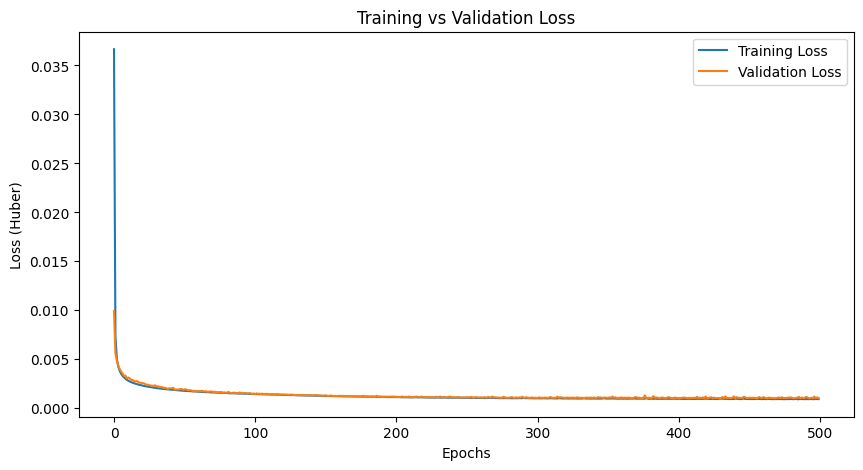

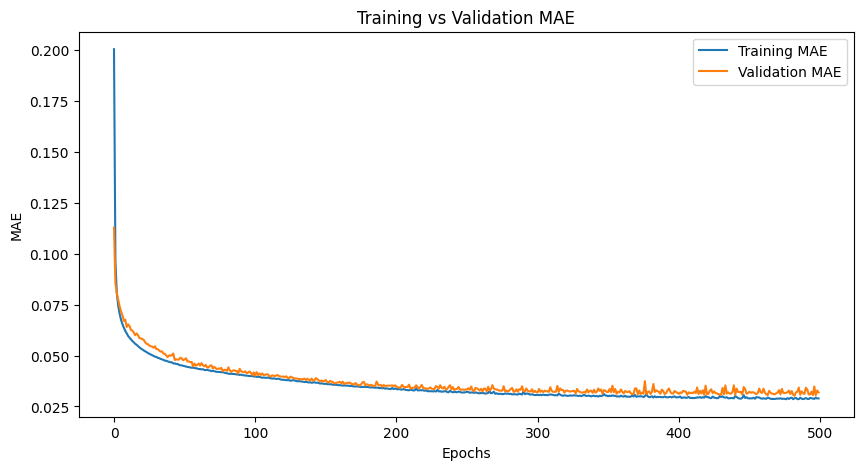

In [89]:
plot_history(history=history)

In [90]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 1s 516ms/step


In [91]:
print(Y_pred)

[[0.39575776 0.39972773 0.3544655  0.25869253 0.20634171 0.32524508
  0.38483223 0.39805833 0.38732073 0.3716469  0.263137   0.20520863
  0.32171673 0.38910887]]


In [127]:
X_input = mulvar_valid.to_numpy()[-seq_length:].reshape(1, seq_length, mulvar_valid.shape[1])
Y_pred = ahead_model.predict(X_input, verbose=0)  # shape: (1, 14)
next_14_days_forecast = Y_pred[0] * 1e6
print(next_14_days_forecast)


[256634.77 372751.84 417079.94 473109.25 427435.47 404881.03 312854.4
 264494.3  375601.66 422400.5  436636.06 445311.84 394419.16 318629.28]


# Forecast Using Sequence to Sequence Model

In [114]:
# helper function to make it easier to extract windows from a dataset
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

# Utility function to prepare the dataset for seq-to-seq dataset
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

## Create the dataset with the function

In [115]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [116]:
tf.keras.backend.clear_session()

# Returning the sequence is the only difference to the previous ahead_model
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [117]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

seq2seq_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = seq2seq_model.fit(seq2seq_train, validation_data=seq2seq_valid, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 10s 223ms/step - loss: 0.0780 - mae: 0.3084 - val_loss: 0.0197 - val_mae: 0.1558
Epoch 2/500
33/33 [==============================] - 7s 208ms/step - loss: 0.0148 - mae: 0.1315 - val_loss: 0.0092 - val_mae: 0.1023
Epoch 3/500
33/33 [==============================] - 8s 232ms/step - loss: 0.0093 - mae: 0.1034 - val_loss: 0.0068 - val_mae: 0.0875
Epoch 4/500
33/33 [==============================] - 7s 198ms/step - loss: 0.0074 - mae: 0.0914 - val_loss: 0.0055 - val_mae: 0.0785
Epoch 5/500
33/33 [==============================] - 7s 201ms/step - loss: 0.0062 - mae: 0.0834 - val_loss: 0.0048 - val_mae: 0.0725
Epoch 6/500
33/33 [==============================] - 6s 186ms/step - loss: 0.0054 - mae: 0.0779 - val_loss: 0.0043 - val_mae: 0.0680
Epoch 7/500
33/33 [==============================] - 7s 195ms/step - loss: 0.0049 - mae: 0.0740 - val_loss: 0.0039 - val_mae: 0.0644
Epoch 8/500
33/33 [==============================] - 7s 203ms/step -

Best epoch: 495, Best val_mae: 0.0340
__________________________________________________________________________


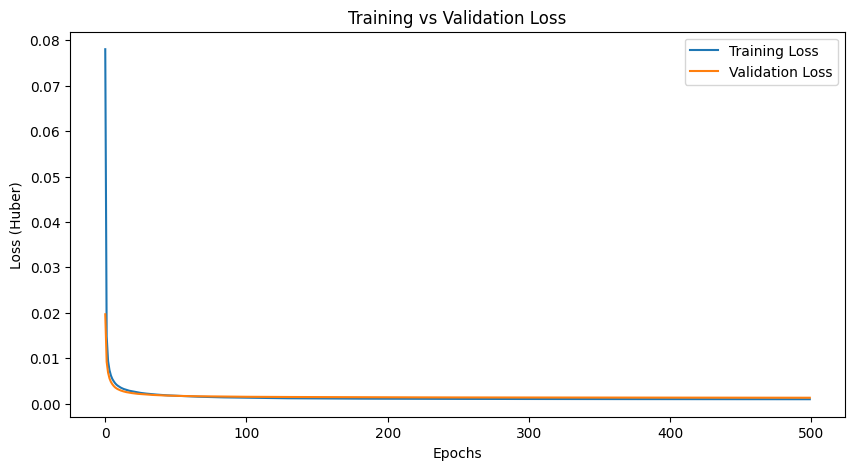

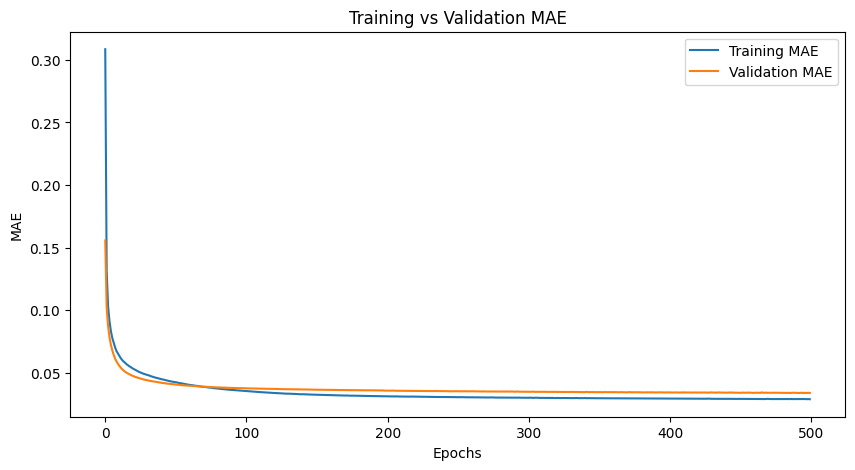

In [118]:
get_val_mae(history=history)
print('__________________________________________________________________________')
plot_history(history=history)

In [119]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output
print('y_pred_14')

1/1 [==============================] - 1s 569ms/step
y_pred_14


In [120]:
print(y_pred_14)

[0.38839078 0.38489437 0.34452093 0.26233754 0.21240896 0.33175933
 0.39694515 0.4004928  0.3814117  0.35224903 0.26912916 0.22278161
 0.33560586 0.3931049 ]


In [128]:
X_input = mulvar_valid.to_numpy()[-seq_length:].reshape(1, seq_length, mulvar_valid.shape[1])
y_pred_14 = seq2seq_model.predict(X_input, verbose=0)[0, 0]  # first step after the input window
print("Next day forecast:", y_pred_14 * 1e6)

Next day forecast: [319293.75 309335.97 288056.56 314114.88 291531.16 275615.88 220081.86
 303423.   300904.44 255021.52 262988.8  265922.66 270294.7  287631.5 ]


# Forecast Comparison

|                          | Seasonal Naive Forecast | ARIMA        | Linear Model  | Simple RNN  | Deep RNN   | Multivar_model | Seq2Seq Model | 14-days ahead Model |
|--------------------------|----------------------:|-------------:|---------------:|-------------:|------------:|---------------:|---------------:|------------------:|
| **MAE**                  | 29,453.49             | 25,162.19    | 23,800         | 20,800       | 22,100      | 20,100         | 34,000         | 30,300            |
| **Forecast (1st June 2025)** | 272,960           | 260,176.11   | 218,240.92     | 260,839.67   | 254,230.56  | 261,113.35     | 319,293.75     | 256,634.77        |
| **Observed**             | 268,696               | 268,696      | 268,696        | 268,696      | 268,696     | 268,696       | 268,696        | 268,696           |
| **Error %**              | 1.58%                 | 3.15%        | 18.73%         | 2.92%        | 5.40%       | 2.90%         | 18.83%         | 4.53%             |

---

### Analysis:

- The **Multivar_model** has the lowest overall MAE (20,100), making it the best model for forecasting rail ridership in the long run.  
- **Simple RNN** is very close in performance, with an MAE of 20,800 and a small next-day error (2.92%).  
- **ARIMA** and the **14-days ahead model** perform reasonably well with moderate errors for this single day.  
- The **Sequence-to-Sequence model** overestimates the next day’s value, resulting in a higher MAE (34,000) and an 18.83% single-day error.  
- **Seasonal Naive Forecast** is surprisingly accurate for the 1st of June, 2025, with a single-day error of 1.58%.  
- **Linear Model** significantly underestimates the next-day ridership (18.73% error), despite a relatively low MAE overall.  

# Layer Normalization Model

In [131]:
 class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)
        
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        
        return norm_outputs, [norm_outputs]

In [134]:
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

custom_ln_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = custom_ln_model.fit(seq2seq_train, validation_data=seq2seq_valid, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 31s 556ms/step - loss: 0.0829 - mae: 0.2870 - val_loss: 0.0153 - val_mae: 0.1175
Epoch 2/500
33/33 [==============================] - 17s 521ms/step - loss: 0.0114 - mae: 0.1037 - val_loss: 0.0092 - val_mae: 0.0889
Epoch 3/500
33/33 [==============================] - 17s 519ms/step - loss: 0.0087 - mae: 0.0907 - val_loss: 0.0076 - val_mae: 0.0818
Epoch 4/500
33/33 [==============================] - 18s 522ms/step - loss: 0.0075 - mae: 0.0851 - val_loss: 0.0067 - val_mae: 0.0772
Epoch 5/500
33/33 [==============================] - 19s 565ms/step - loss: 0.0066 - mae: 0.0809 - val_loss: 0.0061 - val_mae: 0.0740
Epoch 6/500
33/33 [==============================] - 18s 546ms/step - loss: 0.0061 - mae: 0.0787 - val_loss: 0.0056 - val_mae: 0.0715
Epoch 7/500
33/33 [==============================] - 17s 517ms/step - loss: 0.0057 - mae: 0.0768 - val_loss: 0.0052 - val_mae: 0.0695
Epoch 8/500
33/33 [==============================] - 17s 520ms

Best epoch: 494, Best val_mae: 0.0374
___________________________________________________________________________________________________________________


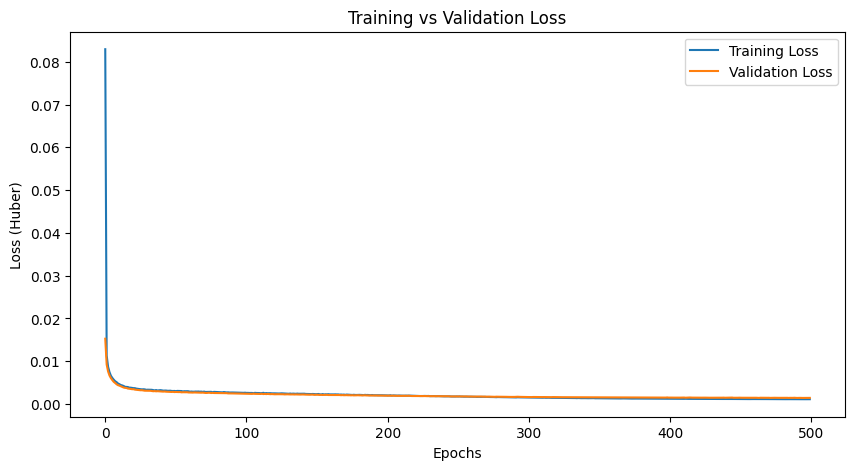

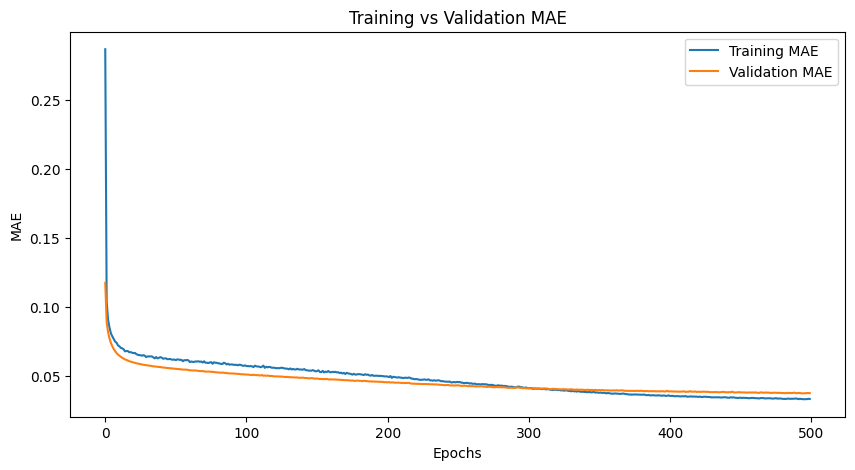

In [135]:
get_val_mae(history=history)
print('___________________________________________________________________________________________________________________')
plot_history(history=history)

In [136]:
X_input = mulvar_valid.to_numpy()[-seq_length:].reshape(1, seq_length, mulvar_valid.shape[1])
y_pred_14 = seq2seq_model.predict(X_input, verbose=0)[0, 0]  # first step after the input window
print("Next day forecast:", y_pred_14 * 1e6)

Next day forecast: [319293.75 309335.97 288056.56 314114.88 291531.16 275615.88 220081.86
 303423.   300904.44 255021.52 262988.8  265922.66 270294.7  287631.5 ]


In [137]:
X_input = mulvar_valid.to_numpy()[-seq_length:].reshape(1, seq_length, mulvar_valid.shape[1])
y_pred_14 = custom_ln_model.predict(X_input, verbose=0)[0, 0]  # first step after the input window
print("Next day forecast:", y_pred_14 * 1e6)

Next day forecast: [350882.8  252851.45 224649.73 309977.75 271587.6  238138.61 262602.47
 308208.56 255258.27 284164.75 244061.58 322511.75 213049.77 226120.38]


# LSTM

In [138]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

lstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = lstm_model.fit(seq2seq_train, validation_data=seq2seq_valid, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 12s 103ms/step - loss: 0.0417 - mae: 0.2613 - val_loss: 0.0145 - val_mae: 0.1445
Epoch 2/500
33/33 [==============================] - 2s 47ms/step - loss: 0.0063 - mae: 0.0940 - val_loss: 0.0051 - val_mae: 0.0860
Epoch 3/500
33/33 [==============================] - 2s 48ms/step - loss: 0.0042 - mae: 0.0747 - val_loss: 0.0044 - val_mae: 0.0794
Epoch 4/500
33/33 [==============================] - 2s 43ms/step - loss: 0.0041 - mae: 0.0729 - val_loss: 0.0043 - val_mae: 0.0784
Epoch 5/500
33/33 [==============================] - 2s 44ms/step - loss: 0.0040 - mae: 0.0723 - val_loss: 0.0042 - val_mae: 0.0777
Epoch 6/500
33/33 [==============================] - 2s 48ms/step - loss: 0.0040 - mae: 0.0719 - val_loss: 0.0042 - val_mae: 0.0774
Epoch 7/500
33/33 [==============================] - 2s 44ms/step - loss: 0.0039 - mae: 0.0714 - val_loss: 0.0041 - val_mae: 0.0769
Epoch 8/500
33/33 [==============================] - 2s 41ms/step - loss: 

Best epoch: 499, Best val_mae: 0.0465
___________________________________________________________________________________________________________________


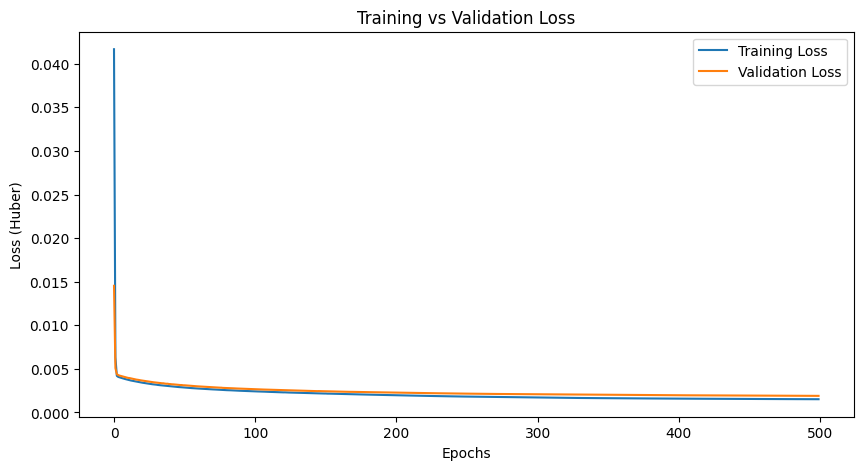

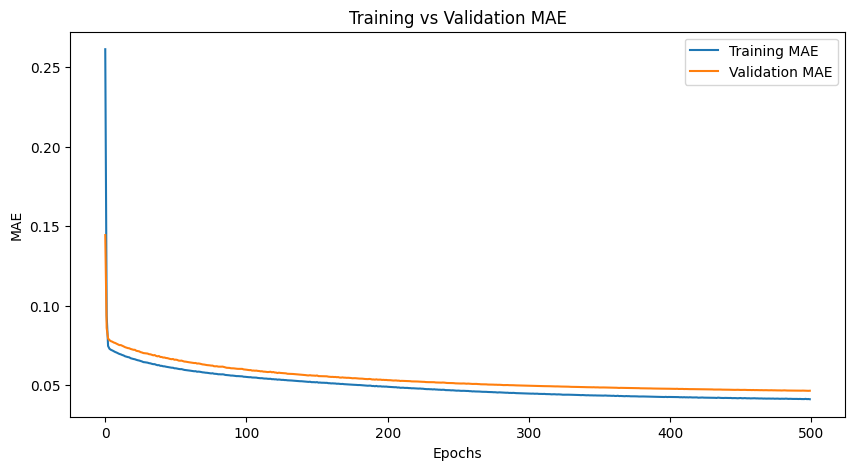

___________________________________________________________________________________________________________________
Next day forecast: [322181.9  290009.56 268438.56 256952.28 239413.97 261382.31 278337.56
 295870.25 287132.2  275421.53 257304.19 259449.84 272121.84 289633.28]


In [139]:
get_val_mae(history=history)
print('___________________________________________________________________________________________________________________')
plot_history(history=history)
print('___________________________________________________________________________________________________________________')
X_input = mulvar_valid.to_numpy()[-seq_length:].reshape(1, seq_length, mulvar_valid.shape[1])
y_pred_14 = lstm_model.predict(X_input, verbose=0)[0, 0]  # first step after the input window
print("Next day forecast:", y_pred_14 * 1e6)

# GRU

In [140]:
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2, activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112, shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)

downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

conv_rnn_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = conv_rnn_model.fit(downsampled_train, validation_data=downsampled_valid, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
31/31 [==============================] - 27s 130ms/step - loss: 0.0327 - mae: 0.2297 - val_loss: 0.0118 - val_mae: 0.1295
Epoch 2/500
31/31 [==============================] - 2s 66ms/step - loss: 0.0049 - mae: 0.0814 - val_loss: 0.0041 - val_mae: 0.0749
Epoch 3/500
31/31 [==============================] - 2s 60ms/step - loss: 0.0038 - mae: 0.0701 - val_loss: 0.0039 - val_mae: 0.0736
Epoch 4/500
31/31 [==============================] - 2s 64ms/step - loss: 0.0037 - mae: 0.0687 - val_loss: 0.0038 - val_mae: 0.0729
Epoch 5/500
31/31 [==============================] - 2s 57ms/step - loss: 0.0036 - mae: 0.0679 - val_loss: 0.0038 - val_mae: 0.0721
Epoch 6/500
31/31 [==============================] - 2s 56ms/step - loss: 0.0035 - mae: 0.0671 - val_loss: 0.0037 - val_mae: 0.0713
Epoch 7/500
31/31 [==============================] - 2s 56ms/step - loss: 0.0034 - mae: 0.0661 - val_loss: 0.0036 - val_mae: 0.0704
Epoch 8/500
31/31 [==============================] - 2s 56ms/step - loss: 

Best epoch: 499, Best val_mae: 0.0358
___________________________________________________________________________________________________________________


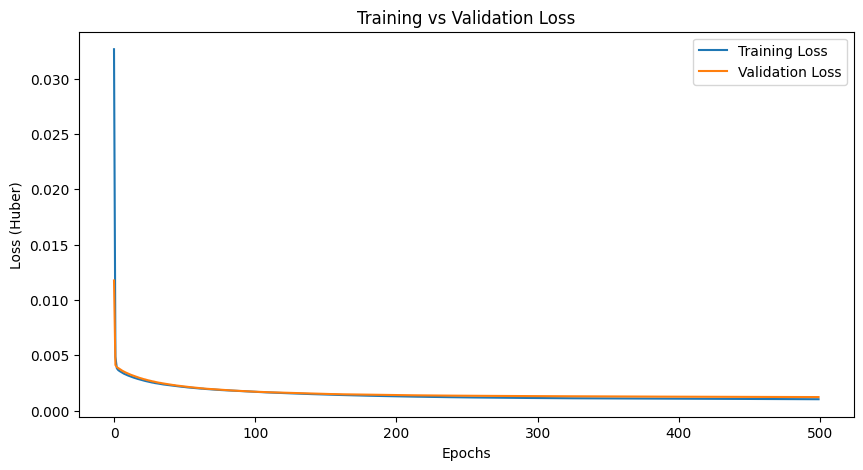

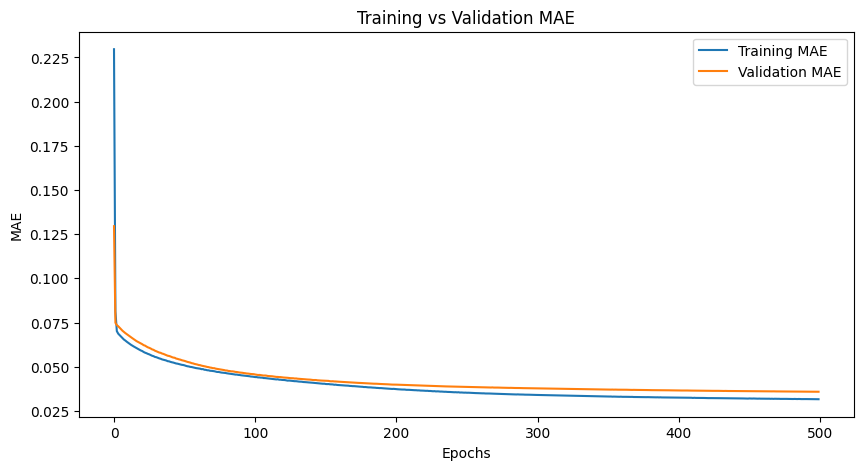

___________________________________________________________________________________________________________________
Next day forecast: [332732.25 276425.97 187984.4  272454.22 321717.16 364486.44 358245.94
 315361.1  300024.47 194755.22 257168.11 358984.2  383732.84 347512.12]


In [141]:
get_val_mae(history=history)
print('___________________________________________________________________________________________________________________')
plot_history(history=history)
print('___________________________________________________________________________________________________________________')
X_input = mulvar_valid.to_numpy()[-seq_length:].reshape(1, seq_length, mulvar_valid.shape[1])
y_pred_14 = conv_rnn_model.predict(X_input, verbose=0)[0, 0]  # first step after the input window
print("Next day forecast:", y_pred_14 * 1e6)

# Wavelenght

In [142]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu",dilation_rate=rate))
    
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

In [143]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

wavenet_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = wavenet_model.fit(downsampled_train, validation_data=downsampled_valid, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500


InvalidArgumentError: Graph execution error:

Detected at node 'huber_loss/Sub' defined at (most recent call last):
    File "C:\Users\conso\.conda\envs\py310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\conso\.conda\envs\py310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\conso\.conda\envs\py310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\conso\.conda\envs\py310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\conso\.conda\envs\py310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\conso\AppData\Local\Temp\ipykernel_5856\2041401795.py", line 5, in <module>
      history = wavenet_model.fit(downsampled_train, validation_data=downsampled_valid, epochs=500, callbacks=[early_stopping_cb])
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\conso\.conda\envs\py310\lib\site-packages\keras\losses.py", line 1879, in huber
      error = tf.subtract(y_pred, y_true)
Node: 'huber_loss/Sub'
required broadcastable shapes
	 [[{{node huber_loss/Sub}}]] [Op:__inference_train_function_810342]

In [ ]:
get_val_mae(history=history)
print('___________________________________________________________________________________________________________________')
plot_history(history=history)
print('___________________________________________________________________________________________________________________')
X_input = mulvar_valid.to_numpy()[-seq_length:].reshape(1, seq_length, mulvar_valid.shape[1])
y_pred_14 = wavenet_model.predict(X_input, verbose=0)[0, 0]  # first step after the input window
print("Next day forecast:", y_pred_14 * 1e6)